# 3D Multi-organ Segmentation using UNETR

#### 1. Import dependencies

In [1]:
import os
import shutil
import tempfile

import matplotlib.pyplot as plt
from tqdm import tqdm

from monai.losses import DiceCELoss
from monai.inferers import sliding_window_inference
from monai.transforms import (
    AsDiscrete,
    EnsureChannelFirstd,
    Compose,
    CropForegroundd,
    LoadImaged,
    Orientationd,
    RandFlipd,
    RandCropByPosNegLabeld,
    RandShiftIntensityd,
    ScaleIntensityRanged,
    Spacingd,
    RandRotate90d,
)

from monai.config import print_config
from monai.metrics import DiceMetric
from monai.networks.nets import UNETR

from monai.data import (
    DataLoader,
    CacheDataset,
    load_decathlon_datalist,
    decollate_batch,
)


import torch

#### 2. Setup data directory

In [2]:
root_dir = '/home/user/Documents/Sushant/UNETR' #specify the root directory

#### Setup Image transform for train and val dataset

In [3]:
train_transforms = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        EnsureChannelFirstd(keys=["image", "label"]),
        Orientationd(keys=["image", "label"], axcodes="RAS"),
        Spacingd(
            keys=["image", "label"],
            pixdim=(1.5, 1.5, 2.0),
            mode=("bilinear", "nearest"),
        ),
        ScaleIntensityRanged(
            keys=["image"],
            a_min=-175,
            a_max=250,
            b_min=0.0,
            b_max=1.0,
            clip=True,
        ),
        CropForegroundd(keys=["image", "label"], source_key="image"),
        RandCropByPosNegLabeld(
            keys=["image", "label"],
            label_key="label",
            spatial_size=(96, 96, 96),
            pos=1,
            neg=1,
            num_samples=4,
            image_key="image",
            image_threshold=0,
        ),
        RandFlipd(
            keys=["image", "label"],
            spatial_axis=[0],
            prob=0.10,
        ),
        RandFlipd(
            keys=["image", "label"],
            spatial_axis=[1],
            prob=0.10,
        ),
        RandFlipd(
            keys=["image", "label"],
            spatial_axis=[2],
            prob=0.10,
        ),
        RandRotate90d(
            keys=["image", "label"],
            prob=0.10,
            max_k=3,
        ),
        RandShiftIntensityd(
            keys=["image"],
            offsets=0.10,
            prob=0.50,
        ),
    ]
)
val_transforms = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        EnsureChannelFirstd(keys=["image", "label"]),
        Orientationd(keys=["image", "label"], axcodes="RAS"),
        Spacingd(
            keys=["image", "label"],
            pixdim=(1.5, 1.5, 2.0),
            mode=("bilinear", "nearest"),
        ),
        ScaleIntensityRanged(keys=["image"], a_min=-175, a_max=250, b_min=0.0, b_max=1.0, clip=True),
        CropForegroundd(keys=["image", "label"], source_key="image"),
    ]
)
test_transforms = Compose(
    [
        LoadImaged(keys=["image"]),
        EnsureChannelFirstd(keys=["image"]),
        Orientationd(keys=["image"], axcodes="RAS"),
        Spacingd(
            keys=["image"],
            pixdim=(1.5, 1.5, 2.0),
            mode=("bilinear"),
        ),
        ScaleIntensityRanged(
            keys=["image"],
            a_min=-175,
            a_max=250,
            b_min=0.0,
            b_max=1.0,
            clip=True,
        ),
        CropForegroundd(keys=["image"], source_key="image"),
    ]
)

/home/user/miniconda3/envs/unetr/lib/python3.10/site-packages/monai/utils/deprecate_utils.py:321: FutureWarning: monai.transforms.croppad.dictionary CropForegroundd.__init__:allow_smaller: Current default value of argument `allow_smaller=True` has been deprecated since version 1.2. It will be changed to `allow_smaller=False` in version 1.5.
  warn_deprecated(argname, msg, warning_category)


#### 3. Loading the dataset

In [5]:
data_dir = "/home/user/Documents/Sushant/UNETR/data/"
split_json = "dataset.json"

datasets = data_dir + split_json
datalist = load_decathlon_datalist(datasets, True, "training")
val_files = load_decathlon_datalist(datasets, True, "validation")


import json
import os

# Load raw JSON
with open(os.path.join(data_dir, split_json)) as f:
    dataset = json.load(f)

# Prepare test files (wrap each image path into a dict)
test_files = [{"image": os.path.join(data_dir, path)} for path in dataset["test"]]


train_ds = CacheDataset(
    data=datalist,
    transform=train_transforms,
    cache_num=24,
    cache_rate=1.0,
    num_workers=8,
)
train_loader = DataLoader(
    train_ds, 
    batch_size=1, 
    shuffle=True, 
    num_workers=8, 
    pin_memory=True
    )

val_ds = CacheDataset(
    data=val_files, 
    transform=val_transforms, 
    cache_num=6, 
    cache_rate=1.0, 
    num_workers=4
    )

val_loader = DataLoader(
    val_ds, 
    batch_size=1, 
    shuffle=False, 
    num_workers=4, 
    pin_memory=True
    )

test_ds = CacheDataset(
    data=test_files,
    transform=test_transforms,
    cache_num=20,
    cache_rate=1.0,
    num_workers=4
)

test_loader = DataLoader(
    test_ds,
    batch_size=1,
    shuffle=False,
    num_workers=4,
    pin_memory=True
)


Loading dataset: 100%|██████████| 20/20 [00:11<00:00,  1.81it/s]


#### 4. Visualize the data

image shape: torch.Size([1, 314, 214, 234]), label shape: torch.Size([1, 314, 214, 234])


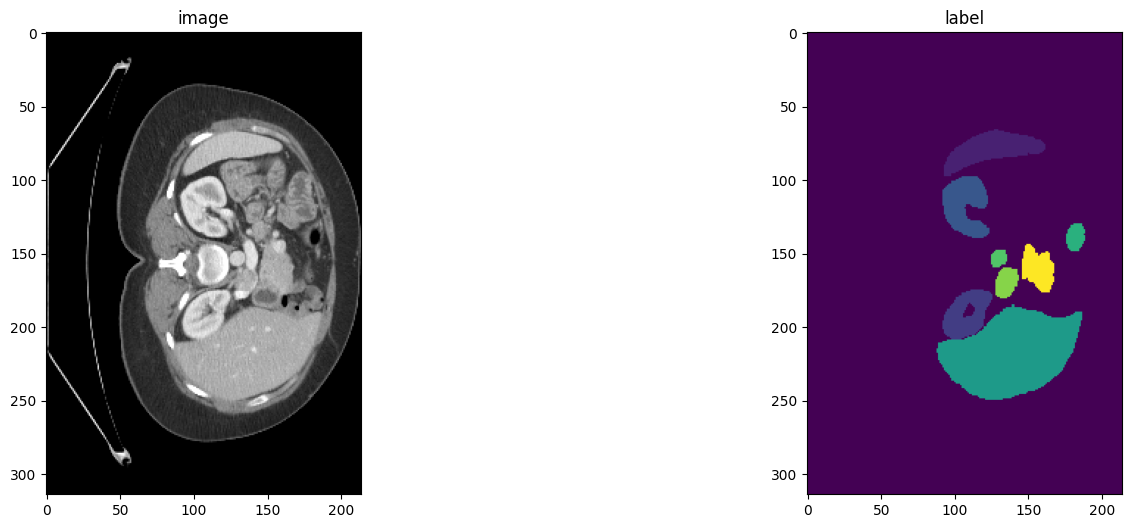

image shape: torch.Size([1, 255, 223, 276]), label shape: torch.Size([1, 255, 223, 276])


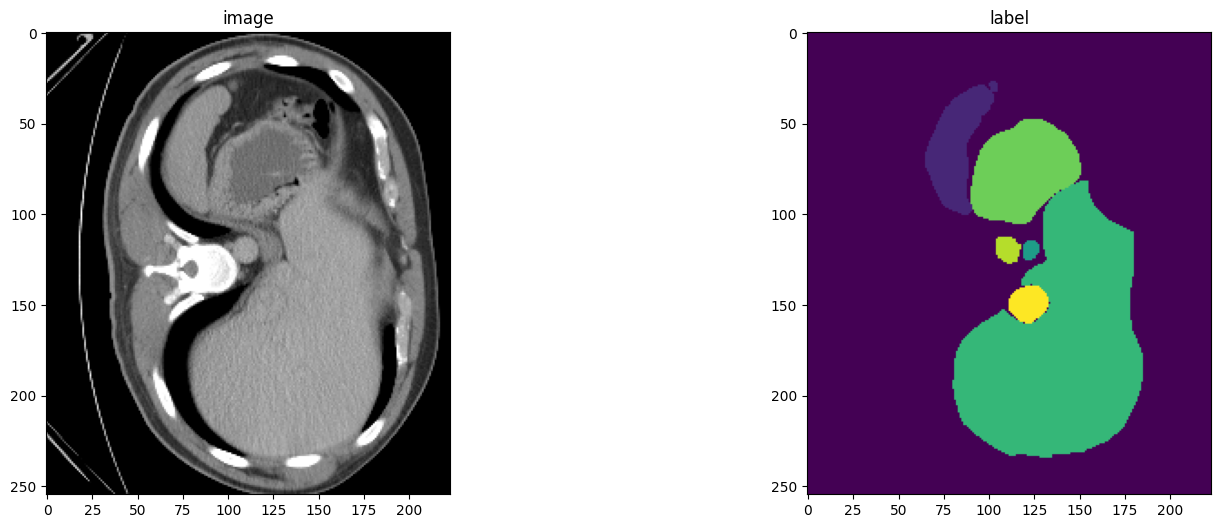

image shape: torch.Size([1, 238, 190, 246]), label shape: torch.Size([1, 238, 190, 246])


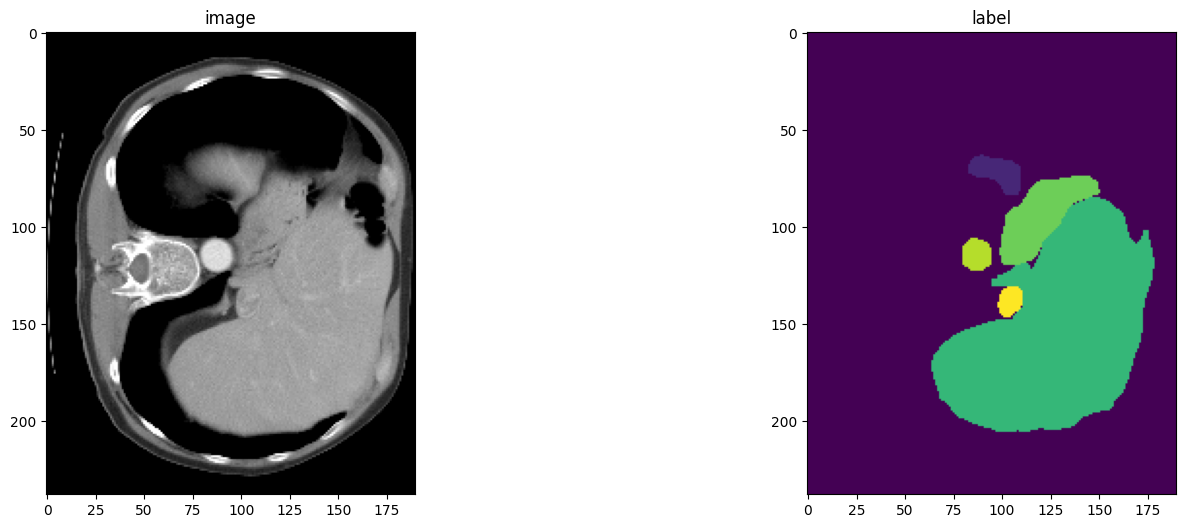

image shape: torch.Size([1, 323, 279, 248]), label shape: torch.Size([1, 323, 279, 248])


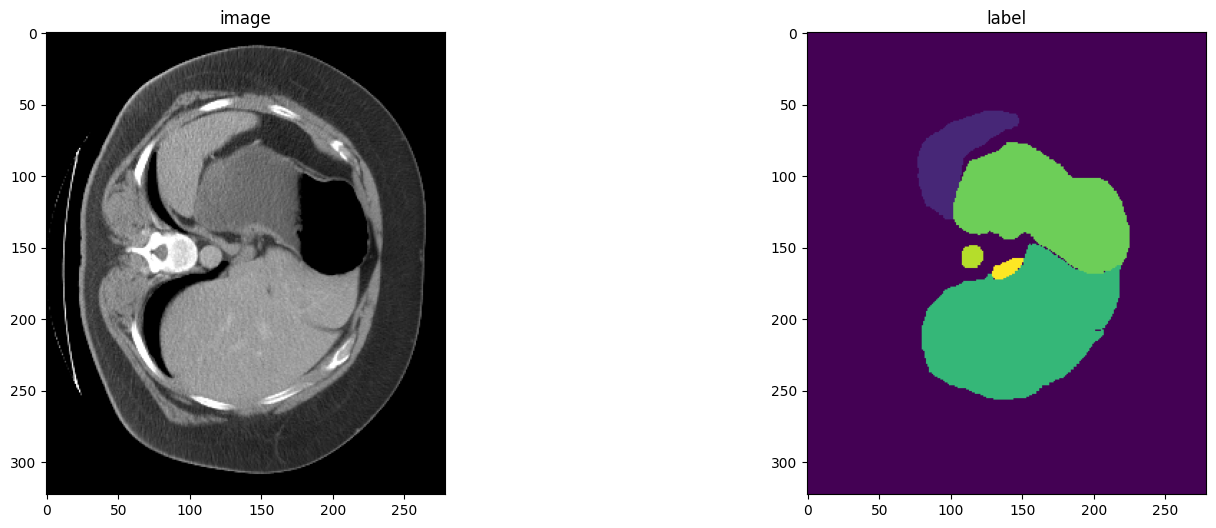

image shape: torch.Size([1, 333, 228, 224]), label shape: torch.Size([1, 333, 228, 224])


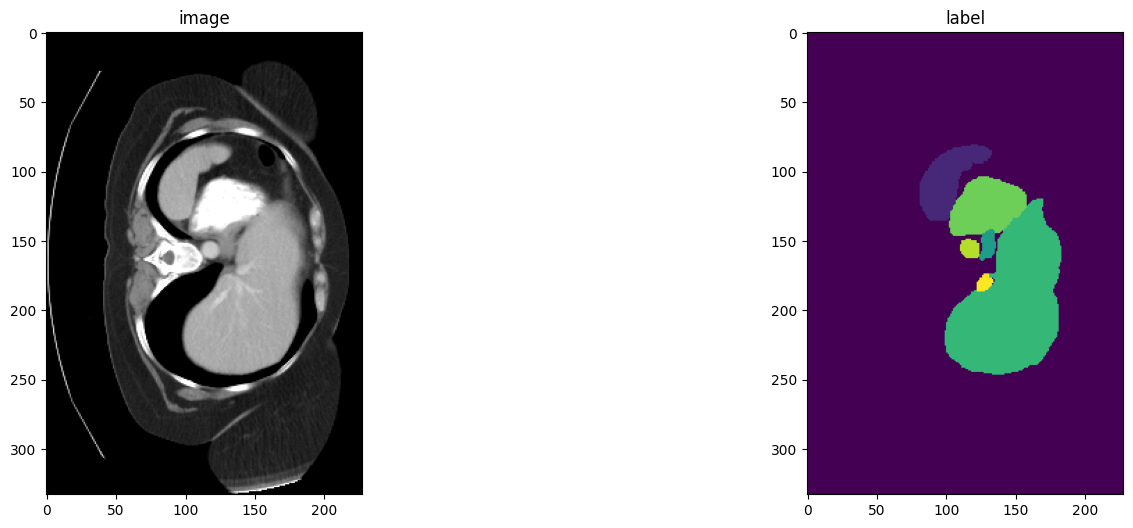

image shape: torch.Size([1, 254, 210, 292]), label shape: torch.Size([1, 254, 210, 292])


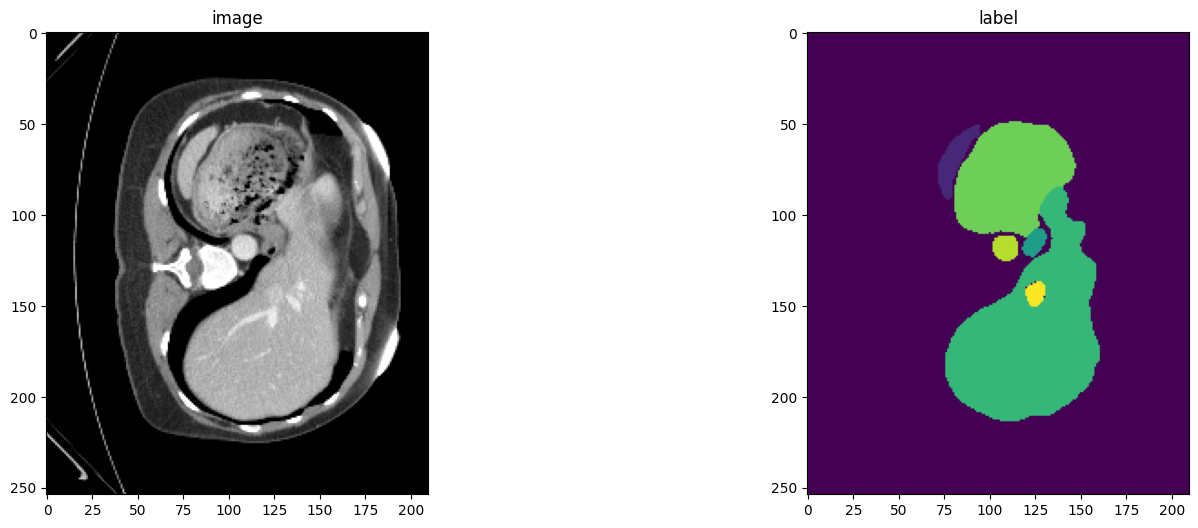

In [6]:
slice_map = {
    "img0035.nii.gz": 170,
    "img0036.nii.gz": 230,
    "img0037.nii.gz": 204,
    "img0038.nii.gz": 204,
    "img0039.nii.gz": 204,
    "img0040.nii.gz": 180,
}
for case_num in range(len(slice_map)):
    img_name = os.path.split(val_ds[case_num]["image"].meta["filename_or_obj"])[1]
    img = val_ds[case_num]["image"]
    label = val_ds[case_num]["label"]
    img_shape = img.shape
    label_shape = label.shape
    print(f"image shape: {img_shape}, label shape: {label_shape}")
    plt.figure("image", (18, 6))
    plt.subplot(1, 2, 1)
    plt.title("image")
    plt.imshow(img[0, :, :, slice_map[img_name]].detach().cpu(), cmap="gray")
    plt.subplot(1, 2, 2)
    plt.title("label")
    plt.imshow(label[0, :, :, slice_map[img_name]].detach().cpu())
    plt.show()

#### 4. Creating Model, loss, optimizer

In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = UNETR(
    in_channels=1,
    out_channels=14,
    img_size=(96, 96, 96),
    feature_size=16,
    hidden_size=768,
    mlp_dim=3072,
    num_heads=12,
    proj_type="perceptron",
    norm_name="instance",
    res_block=True,
    dropout_rate=0.0,
).to(device)

loss_function = DiceCELoss(to_onehot_y=True, softmax=True)
torch.backends.cudnn.benchmark = True
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-5)

#### 5. Training

In [8]:
def validation(epoch_iterator_val):
    model.eval()
    with torch.no_grad():
        for batch in epoch_iterator_val:
            val_inputs, val_labels = (batch["image"].cuda(), batch["label"].cuda())
            val_outputs = sliding_window_inference(val_inputs, (96, 96, 96), 4, model)
            val_labels_list = decollate_batch(val_labels)
            val_labels_convert = [post_label(val_label_tensor) for val_label_tensor in val_labels_list]
            val_outputs_list = decollate_batch(val_outputs)
            val_output_convert = [post_pred(val_pred_tensor) for val_pred_tensor in val_outputs_list]
            dice_metric(y_pred=val_output_convert, y=val_labels_convert)
            epoch_iterator_val.set_description("Validate (%d / %d Steps)" % (global_step, 10.0))  # noqa: B038
        mean_dice_val = dice_metric.aggregate().item()
        dice_metric.reset()
    return mean_dice_val


def train(global_step, train_loader, dice_val_best, global_step_best):
    model.train()
    epoch_loss = 0
    step = 0
    epoch_iterator = tqdm(train_loader, desc="Training (X / X Steps) (loss=X.X)", dynamic_ncols=True)
    for step, batch in enumerate(epoch_iterator):
        step += 1
        x, y = (batch["image"].cuda(), batch["label"].cuda())
        logit_map = model(x)
        loss = loss_function(logit_map, y)
        loss.backward()
        epoch_loss += loss.item()
        optimizer.step()
        optimizer.zero_grad()
        epoch_iterator.set_description(  # noqa: B038
            "Training (%d / %d Steps) (loss=%2.5f)" % (global_step, max_iterations, loss)
        )
        if (global_step % eval_num == 0 and global_step != 0) or global_step == max_iterations:
            epoch_iterator_val = tqdm(val_loader, desc="Validate (X / X Steps) (dice=X.X)", dynamic_ncols=True)
            dice_val = validation(epoch_iterator_val)
            epoch_loss /= step
            epoch_loss_values.append(epoch_loss)
            metric_values.append(dice_val)
            if dice_val > dice_val_best:
                dice_val_best = dice_val
                global_step_best = global_step
                torch.save(model.state_dict(), os.path.join(root_dir, "best_metric_model.pth"))
                print(
                    "Model Was Saved ! Current Best Avg. Dice: {} Current Avg. Dice: {}".format(dice_val_best, dice_val)
                )
            else:
                print(
                    "Model Was Not Saved ! Current Best Avg. Dice: {} Current Avg. Dice: {}".format(
                        dice_val_best, dice_val
                    )
                )
        global_step += 1
    return global_step, dice_val_best, global_step_best


max_iterations = 25000
eval_num = 500
post_label = AsDiscrete(to_onehot=14)
post_pred = AsDiscrete(argmax=True, to_onehot=14)
dice_metric = DiceMetric(include_background=True, reduction="mean", get_not_nans=False)
global_step = 0
dice_val_best = 0.0
global_step_best = 0
epoch_loss_values = []
metric_values = []
while global_step < max_iterations:
    global_step, dice_val_best, global_step_best = train(global_step, train_loader, dice_val_best, global_step_best)
model.load_state_dict(torch.load(os.path.join(root_dir, "best_metric_model.pth"), weights_only=True))

Training (500 / 25000 Steps) (loss=2.45738):  88%|████████▊ | 21/24 [00:13<00:07,  2.41s/it]

Model Was Saved ! Current Best Avg. Dice: 0.07434666156768799 Current Avg. Dice: 0.07434666156768799


Training (1000 / 25000 Steps) (loss=2.08484):  71%|███████   | 17/24 [00:12<00:15,  2.18s/it]

Model Was Saved ! Current Best Avg. Dice: 0.08776579052209854 Current Avg. Dice: 0.08776579052209854


Training (1500 / 25000 Steps) (loss=1.72154):  54%|█████▍    | 13/24 [00:10<00:23,  2.12s/it]

Model Was Saved ! Current Best Avg. Dice: 0.1315394788980484 Current Avg. Dice: 0.1315394788980484


Training (2000 / 25000 Steps) (loss=1.27736):  38%|███▊      | 9/24 [00:09<00:34,  2.32s/it]

Model Was Saved ! Current Best Avg. Dice: 0.13692162930965424 Current Avg. Dice: 0.13692162930965424


Training (2500 / 25000 Steps) (loss=1.36756):  21%|██        | 5/24 [00:09<00:53,  2.80s/it]

Model Was Saved ! Current Best Avg. Dice: 0.14259310066699982 Current Avg. Dice: 0.14259310066699982


Training (3000 / 25000 Steps) (loss=1.27774):   4%|▍         | 1/24 [00:07<02:56,  7.66s/it]

Model Was Saved ! Current Best Avg. Dice: 0.19916264712810516 Current Avg. Dice: 0.19916264712810516


Training (3500 / 25000 Steps) (loss=1.18443):  88%|████████▊ | 21/24 [00:12<00:06,  2.15s/it]

Model Was Saved ! Current Best Avg. Dice: 0.23972827196121216 Current Avg. Dice: 0.23972827196121216


Training (4000 / 25000 Steps) (loss=1.69123):  71%|███████   | 17/24 [00:12<00:16,  2.31s/it]

Model Was Saved ! Current Best Avg. Dice: 0.25606247782707214 Current Avg. Dice: 0.25606247782707214


Training (4500 / 25000 Steps) (loss=1.11476):  54%|█████▍    | 13/24 [00:10<00:23,  2.12s/it]

Model Was Saved ! Current Best Avg. Dice: 0.3353051245212555 Current Avg. Dice: 0.3353051245212555


Training (5000 / 25000 Steps) (loss=1.02295):  38%|███▊      | 9/24 [00:09<00:33,  2.21s/it]

Model Was Saved ! Current Best Avg. Dice: 0.4035690724849701 Current Avg. Dice: 0.4035690724849701


Training (5500 / 25000 Steps) (loss=1.00511):  21%|██        | 5/24 [00:08<00:48,  2.56s/it]

Model Was Saved ! Current Best Avg. Dice: 0.4336344301700592 Current Avg. Dice: 0.4336344301700592


Training (6000 / 25000 Steps) (loss=0.95584):   4%|▍         | 1/24 [00:07<02:53,  7.54s/it]

Model Was Saved ! Current Best Avg. Dice: 0.4562853276729584 Current Avg. Dice: 0.4562853276729584


Training (6500 / 25000 Steps) (loss=1.05505):  88%|████████▊ | 21/24 [00:12<00:06,  2.09s/it]

Model Was Saved ! Current Best Avg. Dice: 0.5063191652297974 Current Avg. Dice: 0.5063191652297974


Training (7000 / 25000 Steps) (loss=0.89707):  71%|███████   | 17/24 [00:11<00:14,  2.11s/it]

Model Was Saved ! Current Best Avg. Dice: 0.5184712409973145 Current Avg. Dice: 0.5184712409973145


Training (7500 / 25000 Steps) (loss=0.97314):  54%|█████▍    | 13/24 [00:10<00:23,  2.12s/it]

Model Was Saved ! Current Best Avg. Dice: 0.5277472138404846 Current Avg. Dice: 0.5277472138404846


Training (8000 / 25000 Steps) (loss=0.92746):  38%|███▊      | 9/24 [00:09<00:32,  2.20s/it]

Model Was Saved ! Current Best Avg. Dice: 0.5374837517738342 Current Avg. Dice: 0.5374837517738342


Training (8500 / 25000 Steps) (loss=0.88169):  21%|██        | 5/24 [00:08<00:49,  2.58s/it]

Model Was Saved ! Current Best Avg. Dice: 0.5592040419578552 Current Avg. Dice: 0.5592040419578552


Training (9000 / 25000 Steps) (loss=0.88628):   4%|▍         | 1/24 [00:07<02:53,  7.55s/it]

Model Was Saved ! Current Best Avg. Dice: 0.5728693604469299 Current Avg. Dice: 0.5728693604469299


Training (9500 / 25000 Steps) (loss=0.91748):  88%|████████▊ | 21/24 [00:12<00:06,  2.11s/it]

Model Was Saved ! Current Best Avg. Dice: 0.5849940776824951 Current Avg. Dice: 0.5849940776824951


Training (10000 / 25000 Steps) (loss=0.92113):  71%|███████   | 17/24 [00:11<00:14,  2.11s/it]

Model Was Saved ! Current Best Avg. Dice: 0.6010898947715759 Current Avg. Dice: 0.6010898947715759


Training (10500 / 25000 Steps) (loss=0.95826):  54%|█████▍    | 13/24 [00:10<00:23,  2.14s/it]

Model Was Saved ! Current Best Avg. Dice: 0.6149879097938538 Current Avg. Dice: 0.6149879097938538


Training (11000 / 25000 Steps) (loss=0.96649):  38%|███▊      | 9/24 [00:09<00:33,  2.20s/it]

Model Was Saved ! Current Best Avg. Dice: 0.6188157200813293 Current Avg. Dice: 0.6188157200813293


Training (11500 / 25000 Steps) (loss=0.90565):  21%|██        | 5/24 [00:07<00:43,  2.28s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.6188157200813293 Current Avg. Dice: 0.603243887424469


Training (12000 / 25000 Steps) (loss=0.68856):   4%|▍         | 1/24 [00:07<02:51,  7.45s/it]

Model Was Saved ! Current Best Avg. Dice: 0.6404281258583069 Current Avg. Dice: 0.6404281258583069


Training (12500 / 25000 Steps) (loss=0.81962):  88%|████████▊ | 21/24 [00:12<00:05,  1.88s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.6404281258583069 Current Avg. Dice: 0.626745343208313


Training (13000 / 25000 Steps) (loss=0.80608):  71%|███████   | 17/24 [00:11<00:13,  1.89s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.6404281258583069 Current Avg. Dice: 0.6131350994110107


Training (13500 / 25000 Steps) (loss=0.67457):  54%|█████▍    | 13/24 [00:09<00:21,  1.91s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.6404281258583069 Current Avg. Dice: 0.6356565952301025


Training (14000 / 25000 Steps) (loss=0.66717):  38%|███▊      | 9/24 [00:09<00:32,  2.19s/it]

Model Was Saved ! Current Best Avg. Dice: 0.6719310879707336 Current Avg. Dice: 0.6719310879707336


Training (14500 / 25000 Steps) (loss=0.89517):  21%|██        | 5/24 [00:08<00:48,  2.58s/it]

Model Was Saved ! Current Best Avg. Dice: 0.6807138323783875 Current Avg. Dice: 0.6807138323783875


Training (15000 / 25000 Steps) (loss=0.79844):   4%|▍         | 1/24 [00:07<02:52,  7.48s/it]

Model Was Saved ! Current Best Avg. Dice: 0.7001014351844788 Current Avg. Dice: 0.7001014351844788


Training (15500 / 25000 Steps) (loss=0.85443):  88%|████████▊ | 21/24 [00:12<00:06,  2.09s/it]

Model Was Saved ! Current Best Avg. Dice: 0.7056611180305481 Current Avg. Dice: 0.7056611180305481


Training (16000 / 25000 Steps) (loss=0.63293):  71%|███████   | 17/24 [00:11<00:14,  2.12s/it]

Model Was Saved ! Current Best Avg. Dice: 0.7141674160957336 Current Avg. Dice: 0.7141674160957336


Training (16500 / 25000 Steps) (loss=0.94159):  54%|█████▍    | 13/24 [00:10<00:23,  2.11s/it]

Model Was Saved ! Current Best Avg. Dice: 0.7322360873222351 Current Avg. Dice: 0.7322360873222351


Training (17000 / 25000 Steps) (loss=0.97652):  38%|███▊      | 9/24 [00:08<00:29,  1.98s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.7322360873222351 Current Avg. Dice: 0.7277736663818359


Training (17500 / 25000 Steps) (loss=0.88485):  21%|██        | 5/24 [00:07<00:43,  2.28s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.7322360873222351 Current Avg. Dice: 0.7172948718070984


Training (18000 / 25000 Steps) (loss=0.68066):   4%|▍         | 1/24 [00:07<02:49,  7.37s/it]

Model Was Saved ! Current Best Avg. Dice: 0.7475304007530212 Current Avg. Dice: 0.7475304007530212


Training (18500 / 25000 Steps) (loss=0.67412):  88%|████████▊ | 21/24 [00:12<00:06,  2.11s/it]

Model Was Saved ! Current Best Avg. Dice: 0.7638058662414551 Current Avg. Dice: 0.7638058662414551


Training (19000 / 25000 Steps) (loss=0.65918):  71%|███████   | 17/24 [00:11<00:14,  2.09s/it]

Model Was Saved ! Current Best Avg. Dice: 0.7688918709754944 Current Avg. Dice: 0.7688918709754944


Training (19500 / 25000 Steps) (loss=0.78864):  54%|█████▍    | 13/24 [00:09<00:21,  1.91s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.7688918709754944 Current Avg. Dice: 0.7653093338012695


Training (20000 / 25000 Steps) (loss=1.02799):  38%|███▊      | 9/24 [00:09<00:33,  2.21s/it]

Model Was Saved ! Current Best Avg. Dice: 0.7724719643592834 Current Avg. Dice: 0.7724719643592834


Training (20500 / 25000 Steps) (loss=0.82581):  21%|██        | 5/24 [00:08<00:48,  2.58s/it]

Model Was Saved ! Current Best Avg. Dice: 0.7765176296234131 Current Avg. Dice: 0.7765176296234131


Training (21000 / 25000 Steps) (loss=0.73210):   4%|▍         | 1/24 [00:07<02:52,  7.50s/it]

Model Was Saved ! Current Best Avg. Dice: 0.7870983481407166 Current Avg. Dice: 0.7870983481407166


Training (21500 / 25000 Steps) (loss=0.80988):  88%|████████▊ | 21/24 [00:11<00:05,  1.87s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.7870983481407166 Current Avg. Dice: 0.7846474647521973


Training (22000 / 25000 Steps) (loss=0.71694):  71%|███████   | 17/24 [00:11<00:13,  1.89s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.7870983481407166 Current Avg. Dice: 0.783141553401947


Training (22500 / 25000 Steps) (loss=0.65370):  54%|█████▍    | 13/24 [00:10<00:23,  2.14s/it]

Model Was Saved ! Current Best Avg. Dice: 0.7900577187538147 Current Avg. Dice: 0.7900577187538147


Training (23000 / 25000 Steps) (loss=0.81232):  38%|███▊      | 9/24 [00:09<00:33,  2.21s/it]

Model Was Saved ! Current Best Avg. Dice: 0.804657518863678 Current Avg. Dice: 0.804657518863678


Training (23500 / 25000 Steps) (loss=0.60584):  21%|██        | 5/24 [00:07<00:43,  2.29s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.804657518863678 Current Avg. Dice: 0.7840456962585449


Training (24000 / 25000 Steps) (loss=0.80309):   4%|▍         | 1/24 [00:06<02:34,  6.73s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.804657518863678 Current Avg. Dice: 0.7895992398262024


Training (24500 / 25000 Steps) (loss=0.68420):  88%|████████▊ | 21/24 [00:12<00:05,  1.89s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.804657518863678 Current Avg. Dice: 0.7877160906791687


Training (25000 / 25000 Steps) (loss=0.70876):  71%|███████   | 17/24 [00:10<00:13,  1.89s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.804657518863678 Current Avg. Dice: 0.78724604845047


Training (25007 / 25000 Steps) (loss=0.88370): 100%|██████████| 24/24 [00:12<00:00,  1.87it/s]


<All keys matched successfully>

In [9]:
print(f"train completed, best_metric: {dice_val_best:.4f} " f"at iteration: {global_step_best}")

train completed, best_metric: 0.8047 at iteration: 23000


#### 6. Plot Train and Val Loss

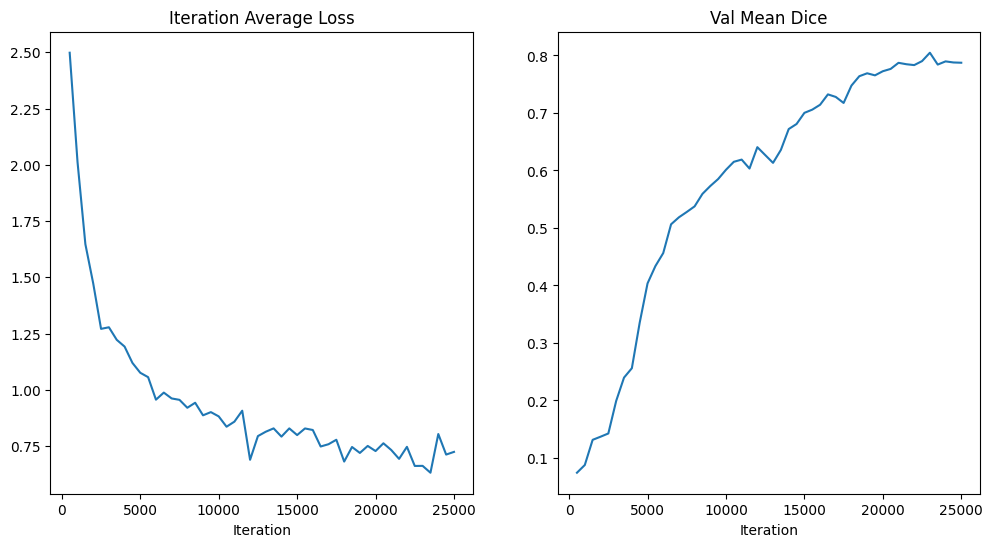

In [10]:
plt.figure("train", (12, 6))
plt.subplot(1, 2, 1)
plt.title("Iteration Average Loss")
x = [eval_num * (i + 1) for i in range(len(epoch_loss_values))]
y = epoch_loss_values
plt.xlabel("Iteration")
plt.plot(x, y)
plt.subplot(1, 2, 2)
plt.title("Val Mean Dice")
x = [eval_num * (i + 1) for i in range(len(metric_values))]
y = metric_values
plt.xlabel("Iteration")
plt.plot(x, y)
plt.show()

#### 7. Plot predicted segementation

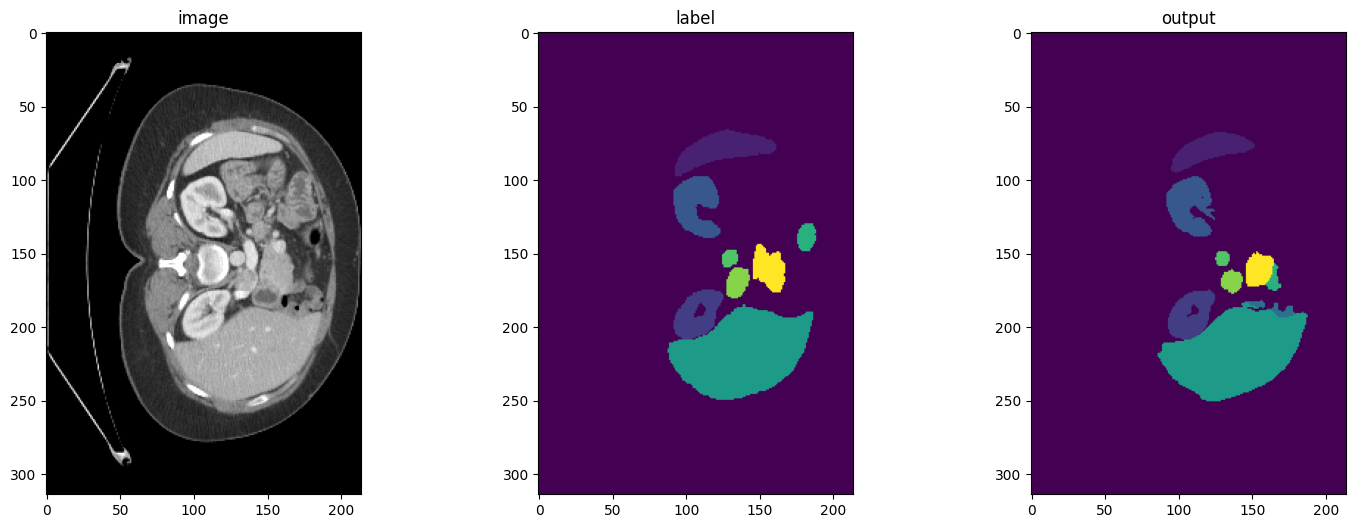

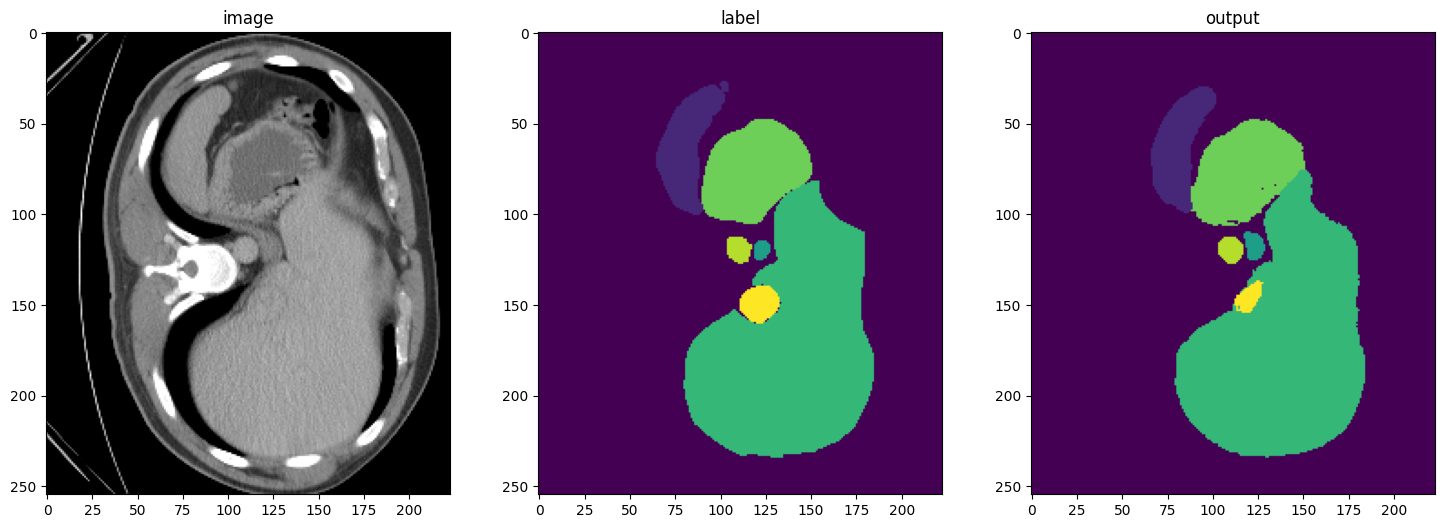

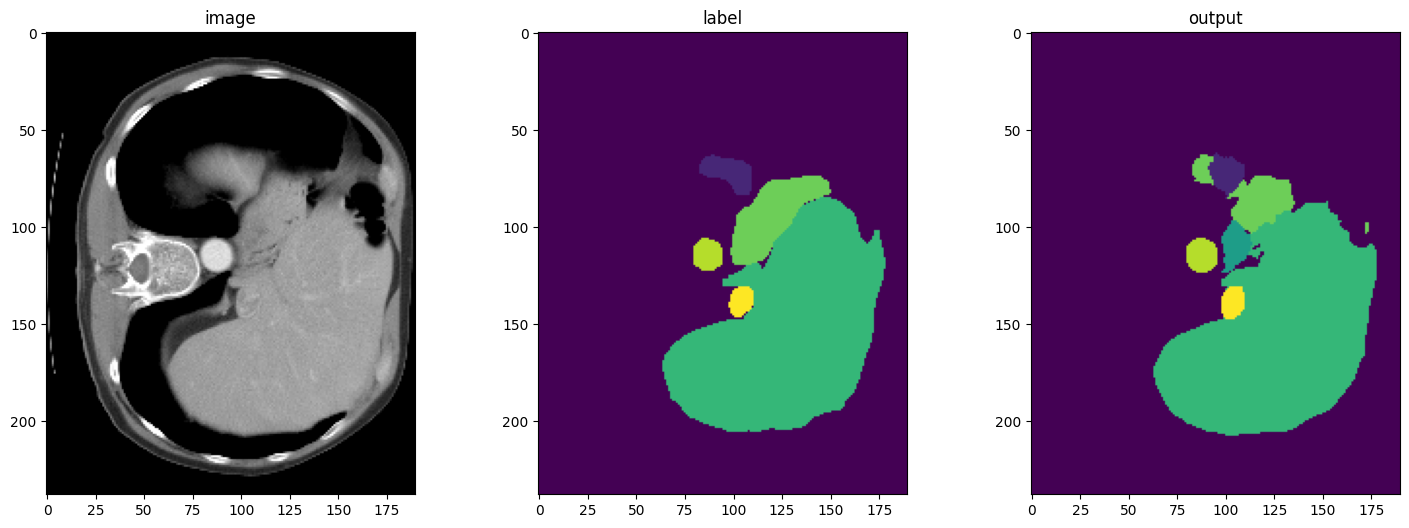

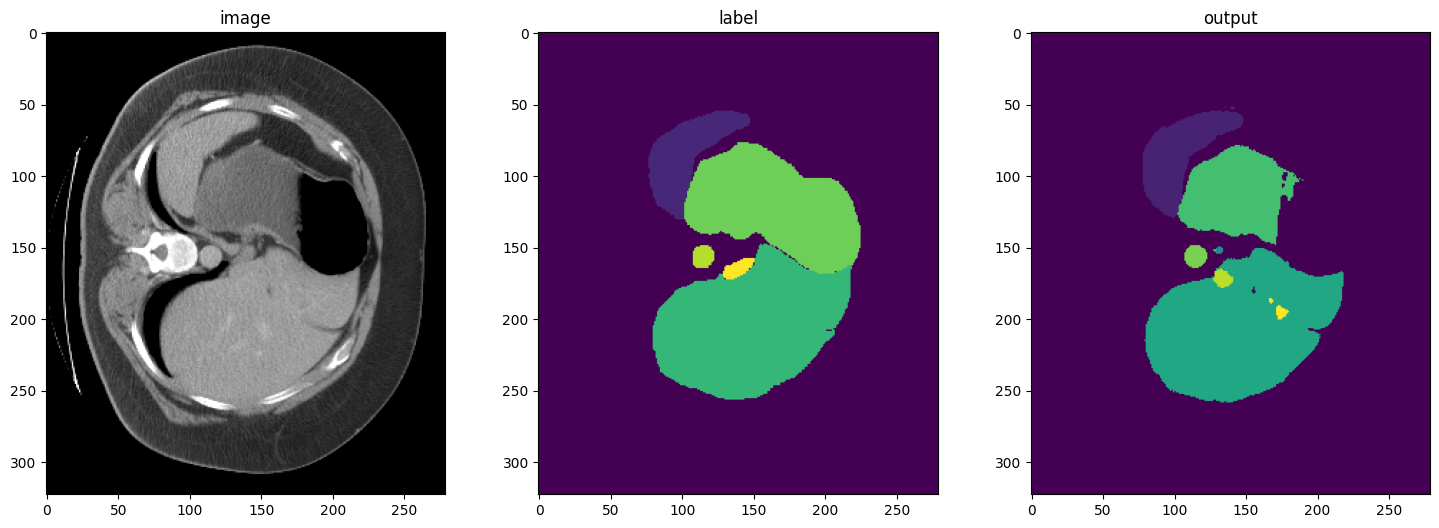

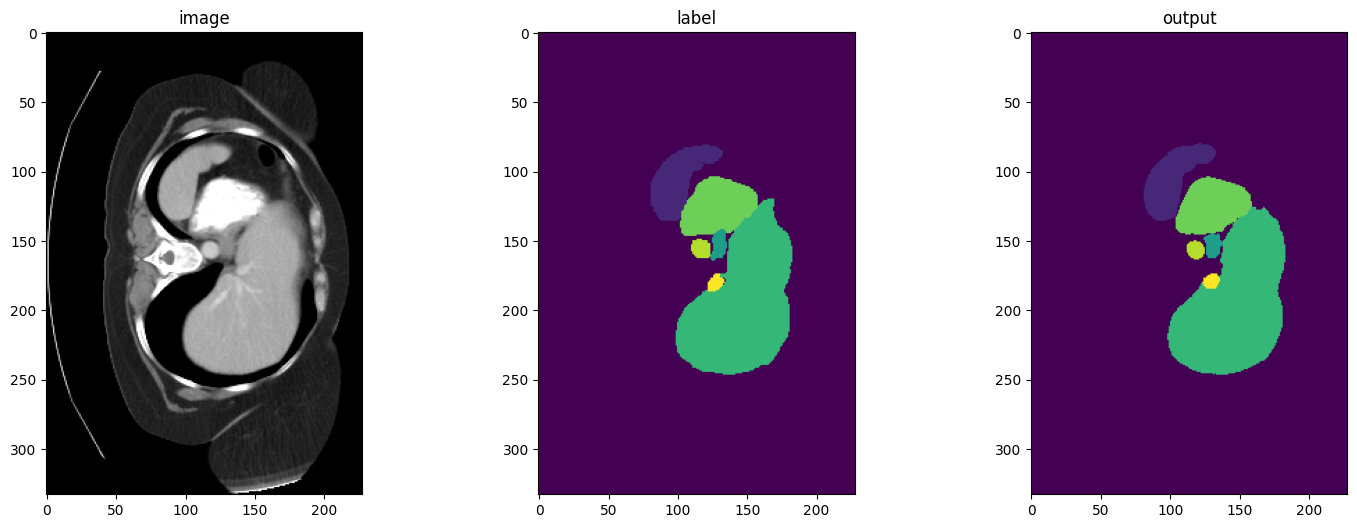

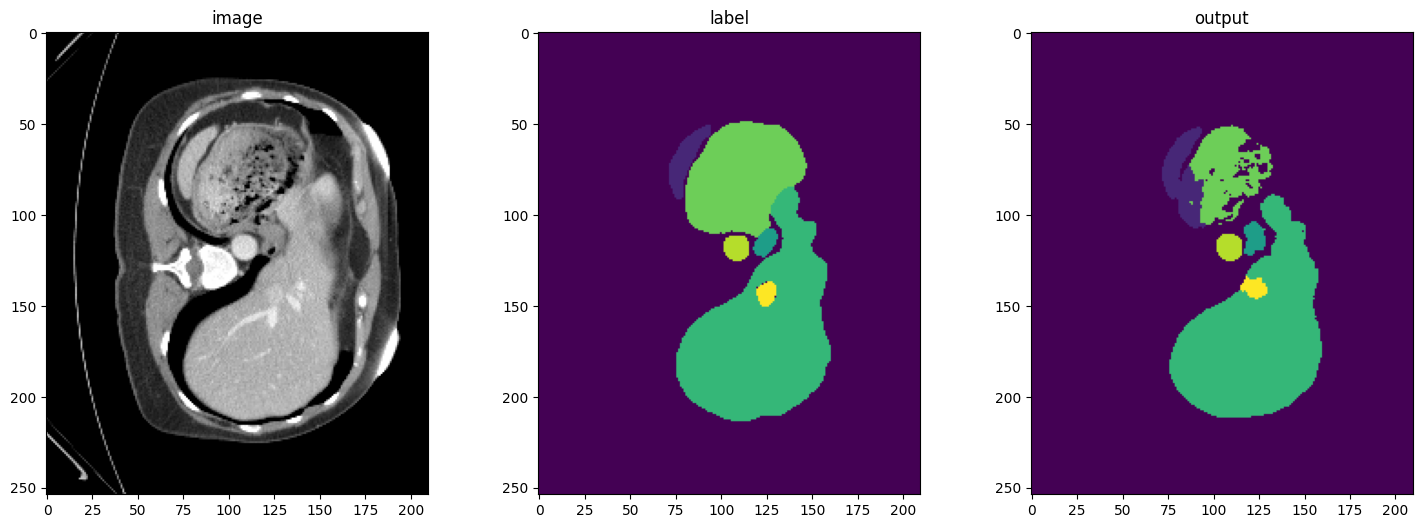

In [11]:
model.load_state_dict(torch.load(os.path.join(root_dir, "best_metric_model.pth"), weights_only=True))
model.eval()

for case_num in range(len(slice_map)):
    with torch.no_grad():
        img_name = os.path.split(val_ds[case_num]["image"].meta["filename_or_obj"])[1]
        img = val_ds[case_num]["image"]
        label = val_ds[case_num]["label"]
        val_inputs = torch.unsqueeze(img, 1).cuda()
        val_labels = torch.unsqueeze(label, 1).cuda()
        val_outputs = sliding_window_inference(val_inputs, (96, 96, 96), 4, model, overlap=0.8)
        plt.figure("check", (18, 6))
        plt.subplot(1, 3, 1)
        plt.title("image")
        plt.imshow(val_inputs.cpu().numpy()[0, 0, :, :, slice_map[img_name]], cmap="gray")
        plt.subplot(1, 3, 2)
        plt.title("label")
        plt.imshow(val_labels.cpu().numpy()[0, 0, :, :, slice_map[img_name]])
        plt.subplot(1, 3, 3)
        plt.title("output")
        plt.imshow(torch.argmax(val_outputs, dim=1).detach().cpu()[0, :, :, slice_map[img_name]])
        plt.show()

#### 8. Predictions on Test Images

In [23]:
depth_map = {
    os.path.basename(sample["image"].meta["filename_or_obj"]): sample["image"].shape[1]
    for sample in test_ds
}

# Print or use it
for name, depth in depth_map.items():
    print(f"{name}: {depth}")


img0061.nii.gz: 234
img0062.nii.gz: 323
img0063.nii.gz: 269
img0064.nii.gz: 266
img0065.nii.gz: 250
img0066.nii.gz: 285
img0067.nii.gz: 274
img0068.nii.gz: 231
img0069.nii.gz: 260
img0070.nii.gz: 249
img0071.nii.gz: 291
img0072.nii.gz: 246
img0073.nii.gz: 187
img0074.nii.gz: 259
img0075.nii.gz: 296
img0076.nii.gz: 267
img0077.nii.gz: 268
img0078.nii.gz: 283
img0079.nii.gz: 297
img0080.nii.gz: 266


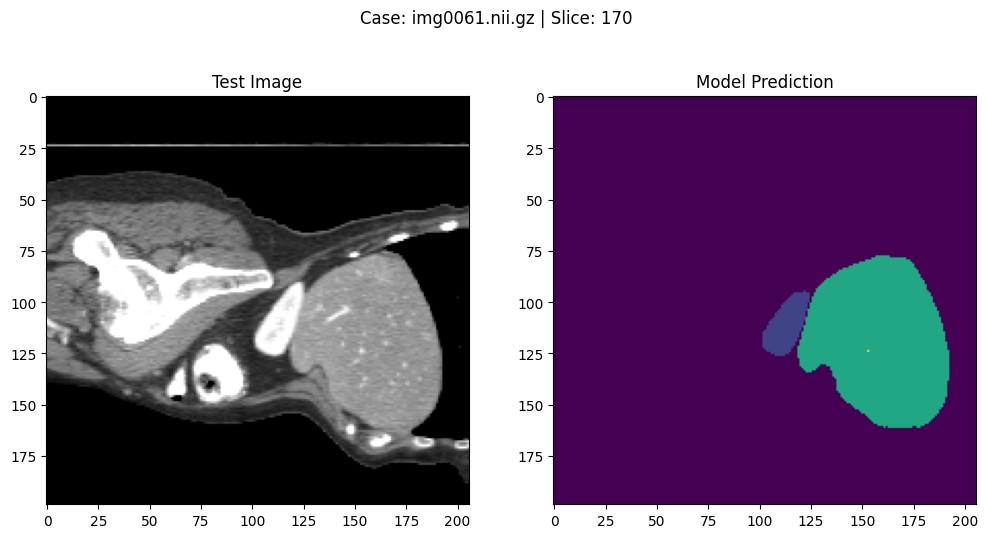

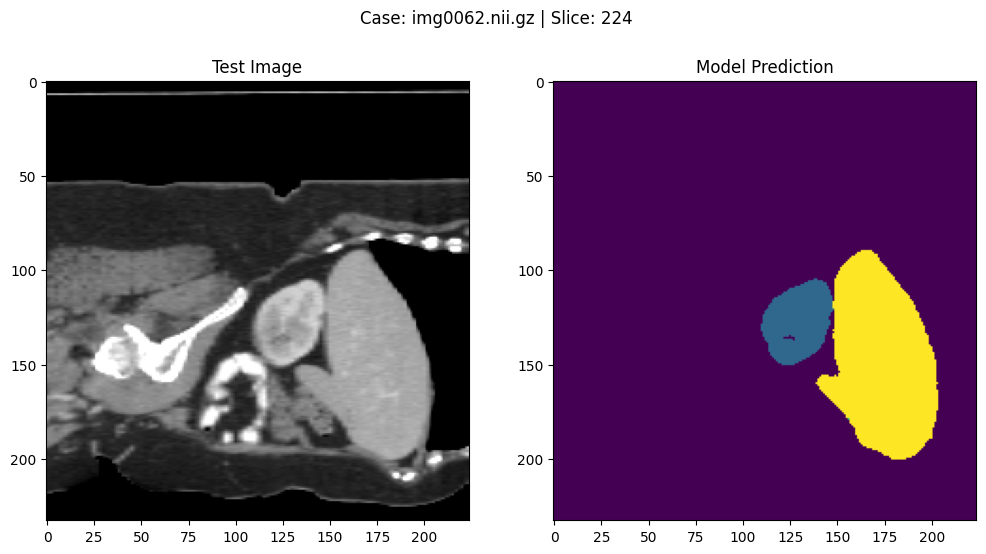

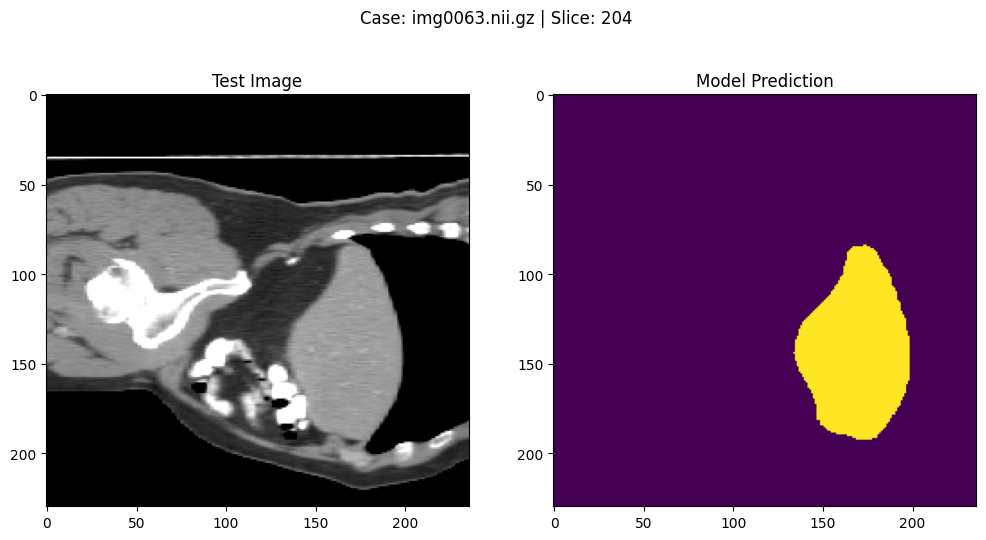

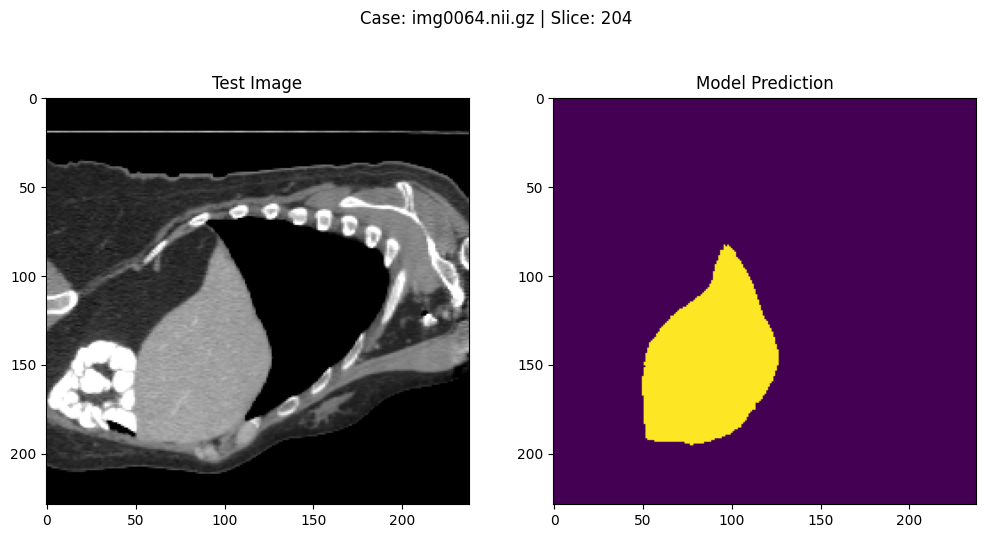

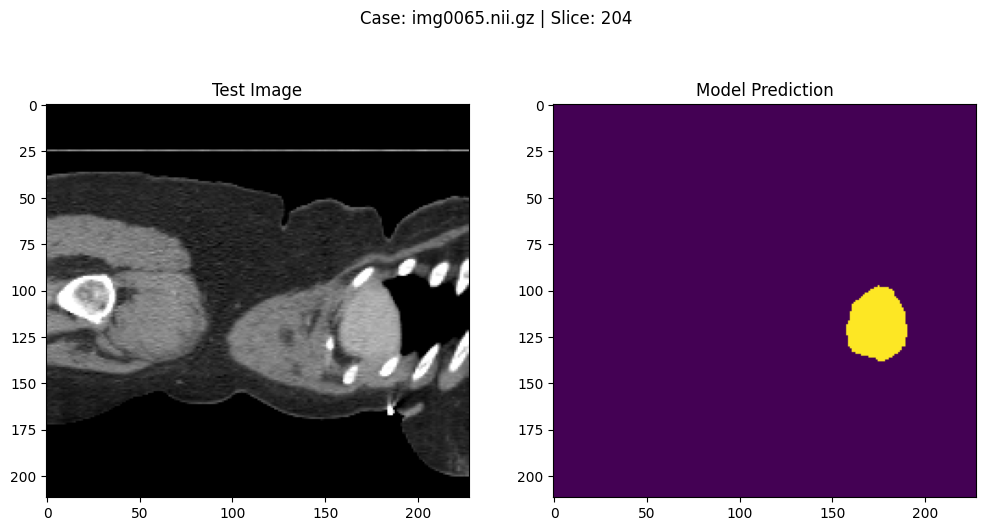

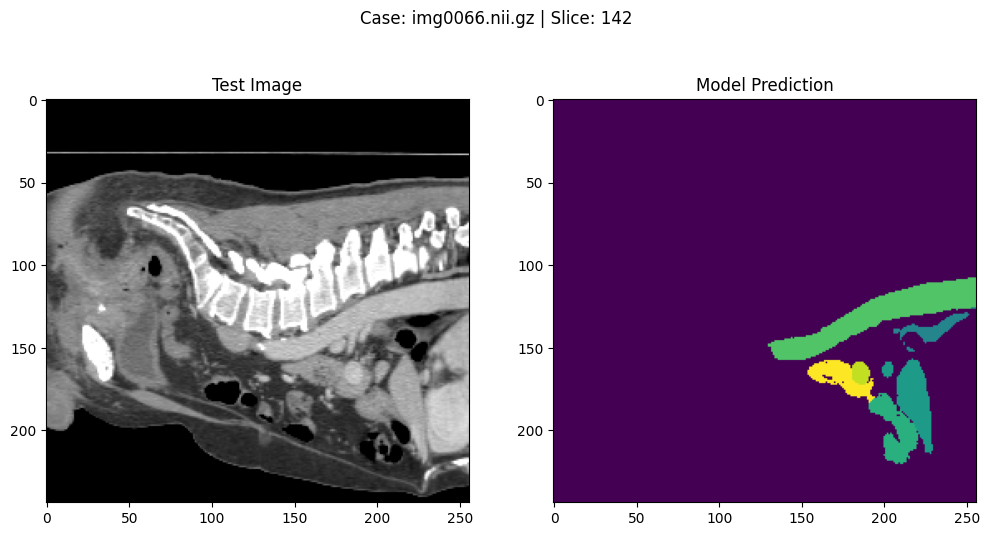

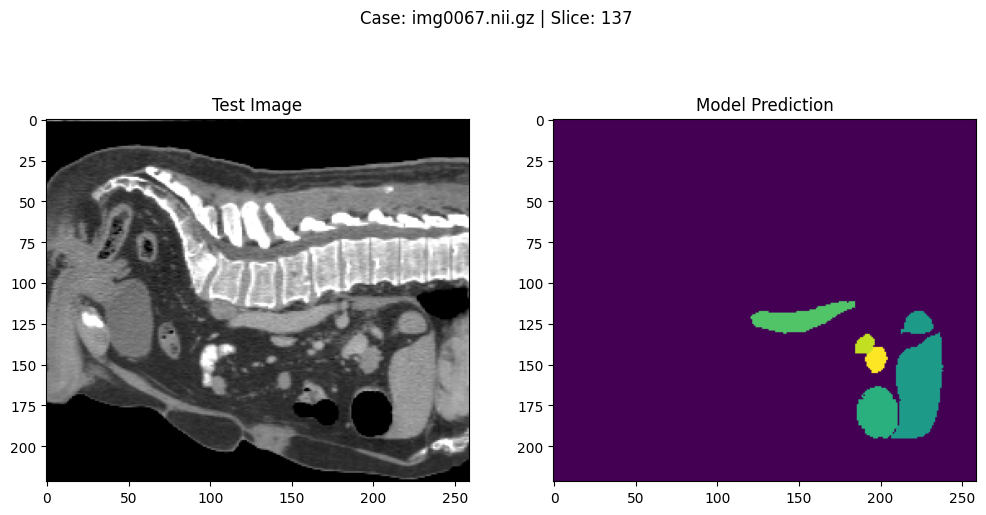

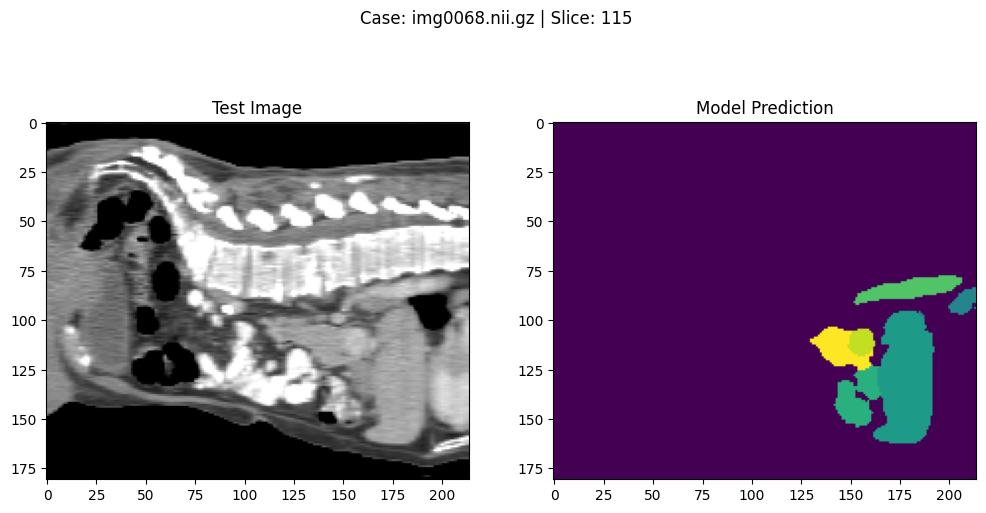

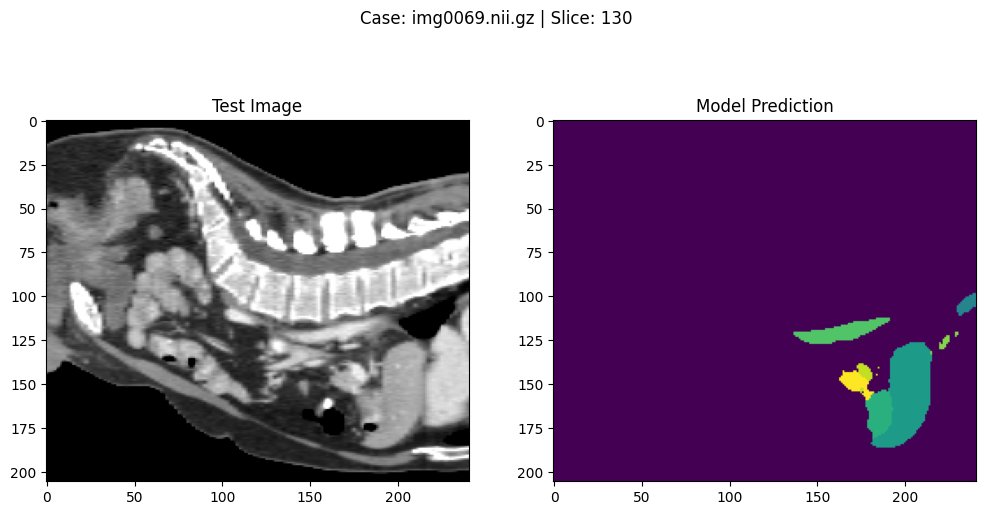

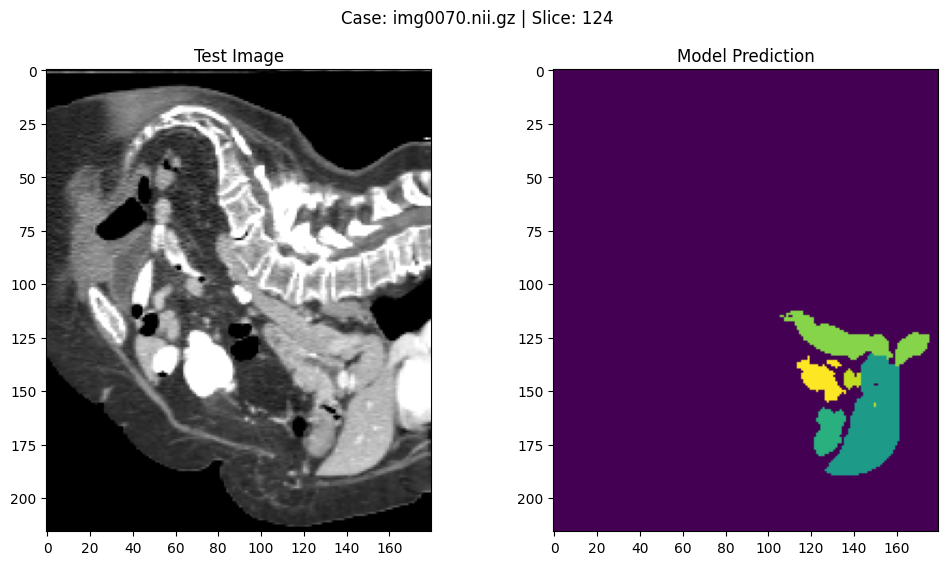

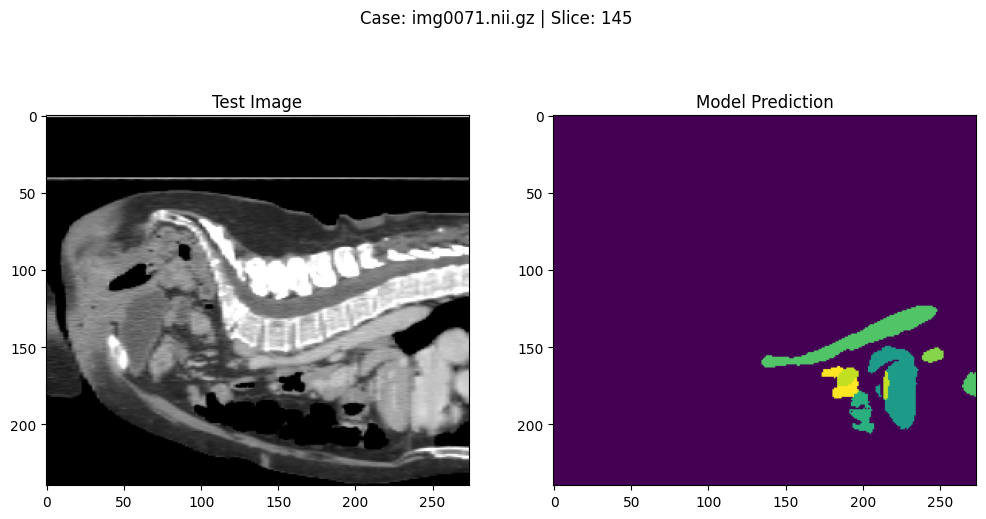

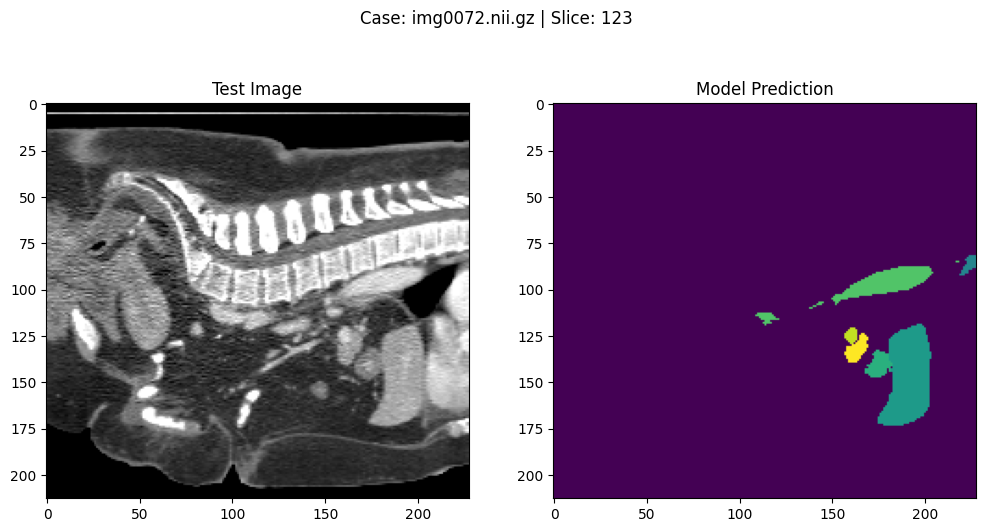

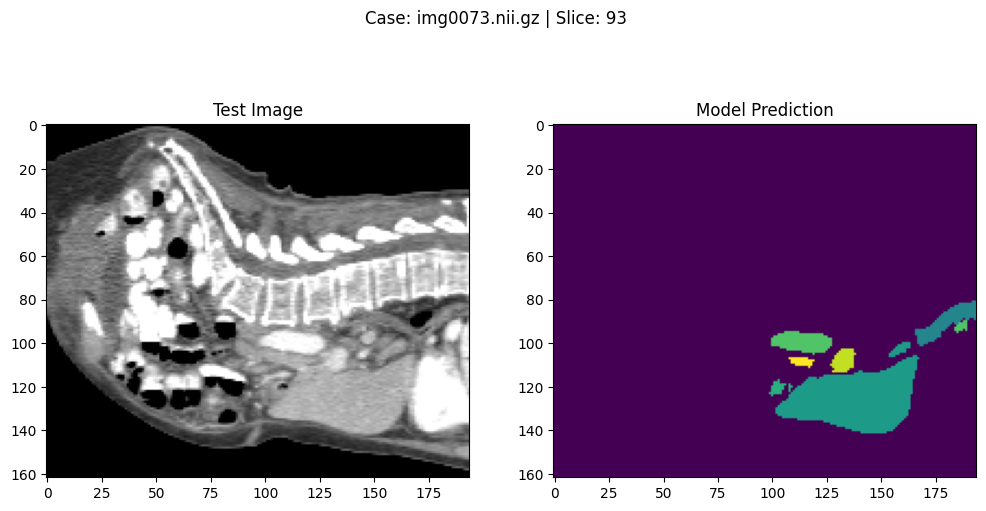

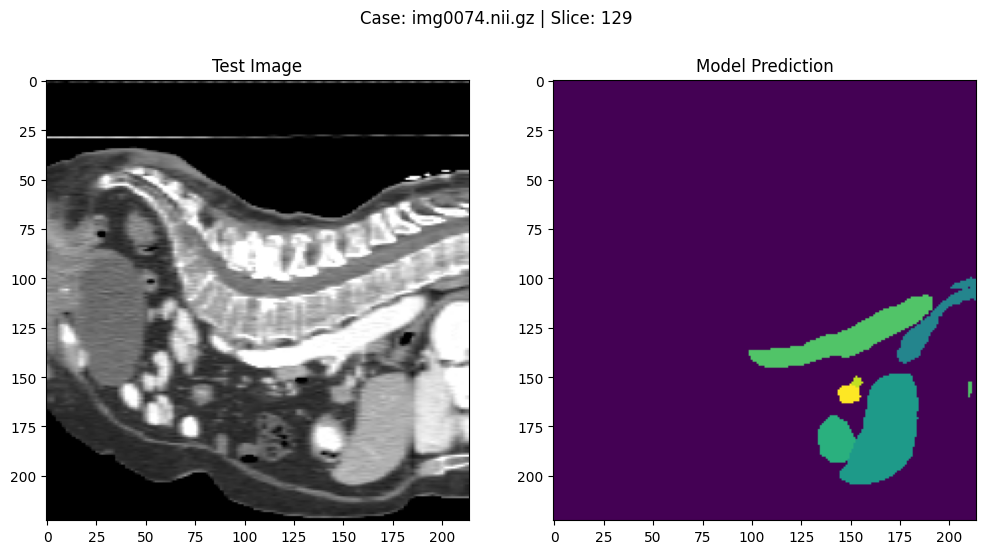

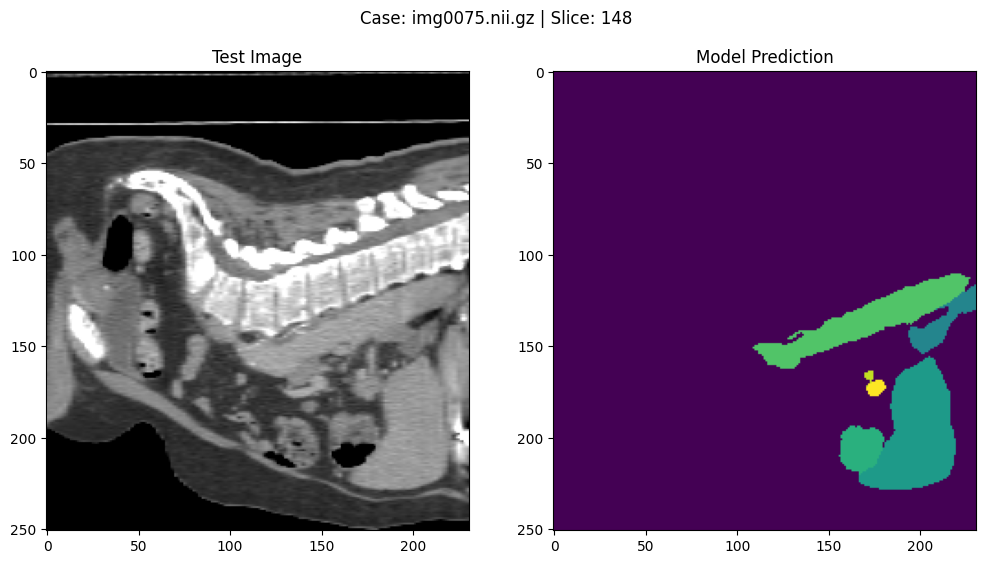

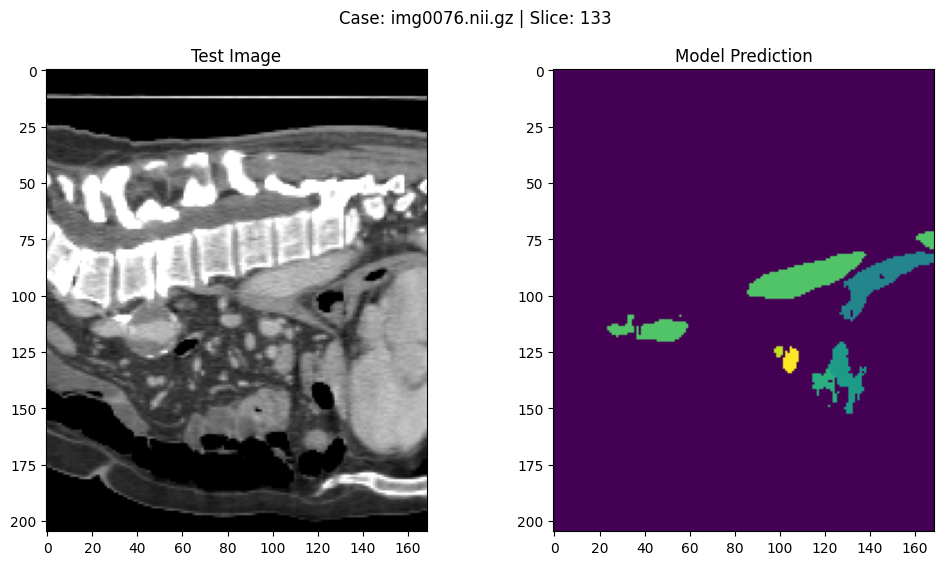

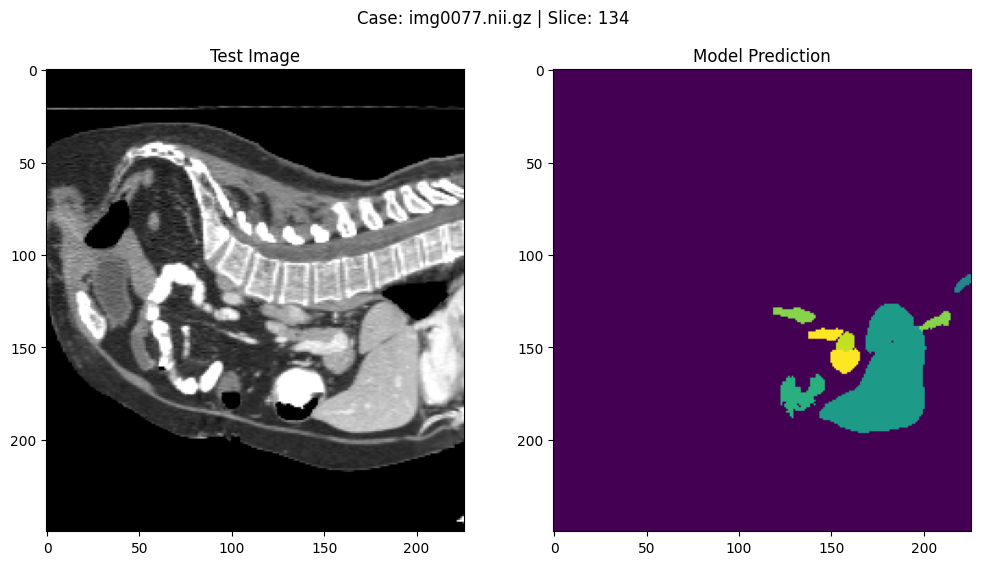

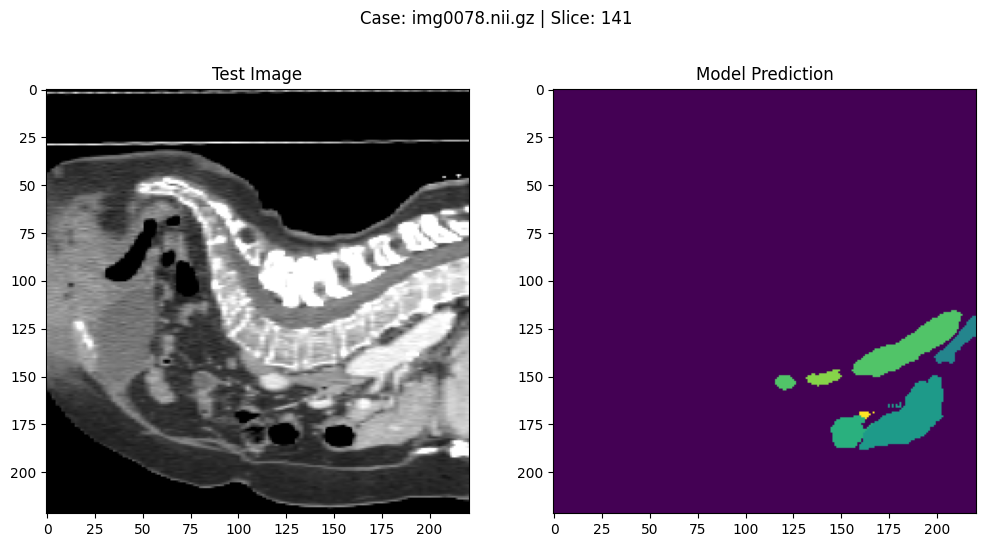

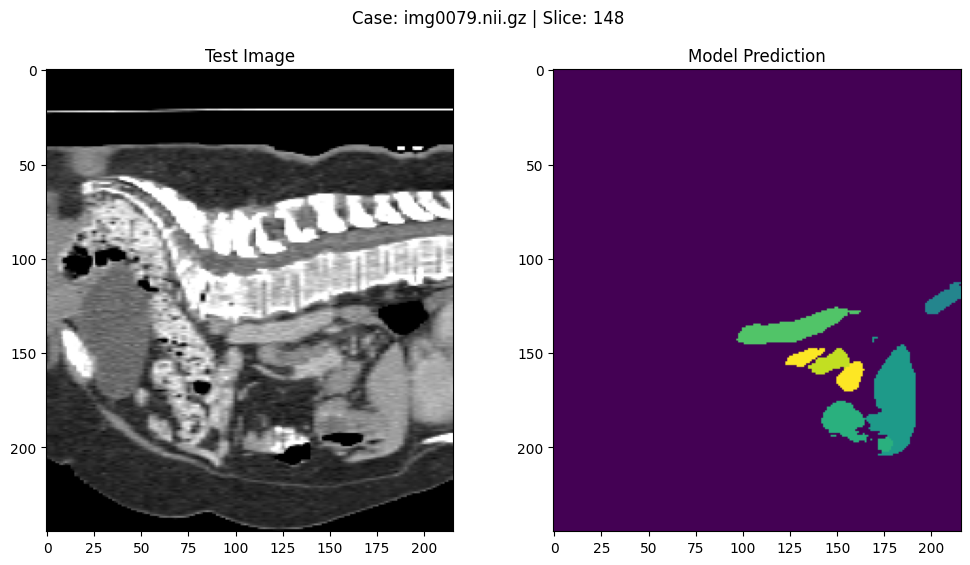

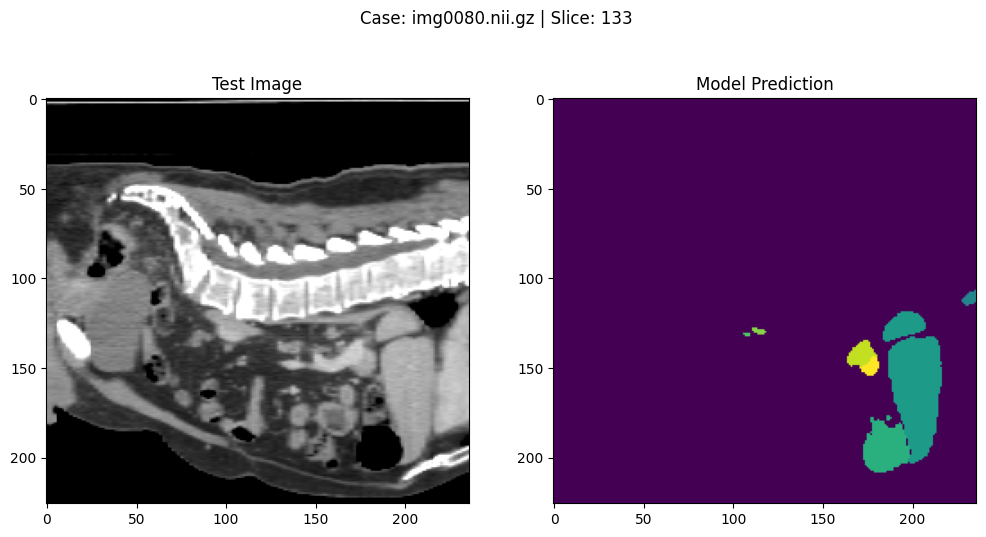

In [28]:
test_slice_maps = {
    "img0061.nii.gz": 170,
    "img0062.nii.gz": 224,
    "img0063.nii.gz": 204,
    "img0064.nii.gz": 204,
    "img0065.nii.gz": 204
}

model.load_state_dict(torch.load(os.path.join(root_dir, "best_metric_model.pth"), weights_only=True))
model.eval()

for case_num in range(len(test_ds)):
    with torch.no_grad():
        sample = test_ds[case_num]
        img_name = os.path.basename(sample["image"].meta["filename_or_obj"])

        img = sample["image"]  # shape: [C, D, H, W]
        test_input = img.unsqueeze(0).cuda()  # [1, 1, D, H, W]

        test_output = sliding_window_inference(test_input, (96, 96, 96), 4, model, overlap=0.8)
        test_pred = torch.argmax(test_output, dim=1).cpu()  # [1, D, H, W]

        # Get slice index from map or use center slice
        slice_idx = test_slice_maps.get(img_name, img.shape[1] // 2)

        plt.figure("test_inference", (12, 6))
        plt.suptitle(f"Case: {img_name} | Slice: {slice_idx}")
        plt.subplot(1, 2, 1)
        plt.title("Test Image")
        plt.imshow(test_input.cpu().numpy()[0, 0, slice_idx, :, :], cmap="gray")

        plt.subplot(1, 2, 2)
        plt.title("Model Prediction")
        plt.imshow(test_pred[0, slice_idx, :, :])
        plt.show()


### Saving the ouput as gifs

In [18]:
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os

save_dir = "./test_gifs"
os.makedirs(save_dir, exist_ok=True)


filename_to_index = {
    os.path.basename(sample["image"].meta["filename_or_obj"]): idx
    for idx, sample in enumerate(test_ds)
}


for img_name, _ in test_slice_maps.items():
    case_num = filename_to_index.get(img_name)
    if case_num is None:
        print(f"{img_name} not found in dataset.")
        continue

    with torch.no_grad():
        sample = test_ds[case_num]
        img = sample["image"]  # [C, D, H, W]
        test_input = img.unsqueeze(0).cuda()

        test_output = sliding_window_inference(test_input, (96, 96, 96), 4, model, overlap=0.8)
        test_pred = torch.argmax(test_output, dim=1).cpu().numpy()[0]  # [D, H, W]
        test_img = test_input.cpu().numpy()[0, 0]  # [D, H, W]

    frames = []
    for i in range(test_img.shape[0]):
        fig, ax = plt.subplots(figsize=(6, 6))
        ax.imshow(test_img[i], cmap="gray")
        ax.imshow(test_pred[i], cmap="jet", alpha=0.4)  # Overlay prediction in color
        ax.axis('off')

        fig.canvas.draw()
        frame = np.frombuffer(fig.canvas.buffer_rgba(), dtype=np.uint8)
        frame = frame.reshape(fig.canvas.get_width_height()[::-1] + (4,))
        frames.append(frame)
        plt.close(fig)


    gif_path = os.path.join(save_dir, f"{img_name.replace('.nii.gz', '')}_overlay.gif")
    imageio.mimsave(gif_path, frames, duration=0.1)  # 10 fps
    print(f"Saved GIF: {gif_path}")


Saved GIF: ./test_gifs/img0061_overlay.gif
Saved GIF: ./test_gifs/img0062_overlay.gif
Saved GIF: ./test_gifs/img0063_overlay.gif
Saved GIF: ./test_gifs/img0064_overlay.gif
Saved GIF: ./test_gifs/img0065_overlay.gif


In [20]:
# Define image filename to dataset index
filename_to_index = {
    os.path.basename(sample["image"].meta["filename_or_obj"]): idx
    for idx, sample in enumerate(test_ds)
}

for img_name, slice_idx in test_slice_maps.items():
    case_idx = filename_to_index[img_name]
    sample = test_ds[case_idx]
    img = sample["image"]
    
    test_input = img.unsqueeze(0).cuda()
    with torch.no_grad():
        test_output = sliding_window_inference(test_input, (96, 96, 96), 4, model, overlap=0.8)
        test_pred = torch.argmax(test_output, dim=1).cpu()[0]

    # Create a GIF across slices with overlays
    frames = []
    for i in range(test_pred.shape[0]):  # iterate across slices (depth axis)
        image_slice = test_input.cpu().numpy()[0, 0, i, :, :]  # [depth, H, W]
        pred_slice = test_pred[i, :, :]  # same shape as image_slice

        fig, ax = plt.subplots(figsize=(6, 6))
        ax.imshow(image_slice, cmap="gray")
        seg_overlay = np.ma.masked_where(pred_slice == 0, pred_slice)
        ax.imshow(seg_overlay, cmap="nipy_spectral", alpha=0.5)
        ax.axis("off")
        fig.canvas.draw()

        frame = np.frombuffer(fig.canvas.buffer_rgba(), dtype=np.uint8)
        frame = frame.reshape(fig.canvas.get_width_height()[::-1] + (4,))
        frames.append(frame)
        plt.close(fig)

    gif_path = os.path.join("gifs", f"{img_name.replace('.nii.gz', '')}_overlay.gif")
    os.makedirs("gifs", exist_ok=True)
    imageio.mimsave(gif_path, frames, fps=5)
    print(f"Saved GIF: {gif_path}")


Saved GIF: gifs/img0061_overlay.gif
Saved GIF: gifs/img0062_overlay.gif
Saved GIF: gifs/img0063_overlay.gif
Saved GIF: gifs/img0064_overlay.gif
Saved GIF: gifs/img0065_overlay.gif
